In [35]:
# 安裝所需套件
from sklearn import metrics
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## EDA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

## 過採樣
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline


# 績效指標
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## 建模
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb

In [36]:
#load data
df2 = pd.read_csv("C:/Users/USER/Desktop/secondphase_test.csv")

# 將與weather_delay無關的特徵刪除
df2.drop(["CRS_DEP_TIME","DEP_TIME","DEP_DELAY","CRS_ARR_TIME","ARR_TIME","ARR_DELAY"
          ,"CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","AIR_TIME"],axis=1,inplace=True)

#將target欄位移至最後一欄
target_col = df2.pop(df2.columns[4])
df2.insert(18, target_col.name, target_col)

In [37]:
df2.describe()

,Day,DISTANCE,DEP_HOUR,ARR_HOUR,DEP_HOURLYVISIBILITY,DEP_HOURLYDewPointTempC,DEP_HOURLYRelativeHumidity,DEP_HOURLYWindSpeed,DEP_HOURLYPrecip,DEP_evaporation,ARR_HOURLYVISIBILITY,ARR_HOURLYDewPointTempC,ARR_HOURLYRelativeHumidity,ARR_HOURLYWindSpeed,ARR_HOURLYPrecip,ARR_evaporation,WEATHER_DELAY
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,16.888889,300.841270,16.253968,17.587302,9.968254,18.976190,53.317460,8.730159,0.003333,5.088889,9.388889,18.852381,60.301587,7.746032,0.013651,4.179365,10.684342
std,8.574364,152.709846,1.950751,1.922993,0.251976,4.255271,19.881768,2.957802,0.019177,1.648666,1.792557,4.323449,22.566486,5.339954,0.051971,1.783812,24.672797
min,1.000000,239.000000,9.000000,11.000000,8.000000,6.700000,20.000000,0.000000,0.000000,1.400000,2.500000,6.700000,18.000000,0.000000,0.000000,0.800000,0.549230
25%,9.000000,239.000000,15.000000,16.000000,10.000000,15.850000,34.500000,7.000000,0.000000,4.000000,10.000000,15.850000,38.500000,5.000000,0.000000,2.800000,1.327094
50%,18.000000,239.000000,17.000000,18.000000,10.000000,20.600000,52.000000,8.000000,0.000000,5.800000,10.000000,20.000000,64.000000,7.000000,0.000000,4.200000,2.064584
75%,25.000000,239.000000,17.000000,19.000000,10.000000,21.950000,69.000000,10.000000,0.000000,6.450000,10.000000,22.200000,79.000000,10.000000,0.000000,5.800000,4.434053
max,30.000000,687.000000,19.000000,22.000000,10.000000,25.000000,90.000000,16.000000,0.150000,6.800000,10.000000,25.600000,94.000000,24.000000,0.370000,6.700000,135.000000


In [38]:
# 1. 類別變數轉換
# 值之間沒有大小的意義，用One-Hot(使用get_dummies)

dummy = pd.get_dummies(df2[['ORIGIN','DEST']])

# 將轉換後產生的dataframe塞入原始df2，並刪除ORIGIN、DEST
df2 = pd.concat([dummy,df2],axis=1)
df2.drop(['ORIGIN','DEST'],axis=1,inplace=True)

In [39]:
# df2['mean_y']= np.log1p(df2["WEATHER_DELAY"]).median()

df2['mean_y']= np.log1p(df2["WEATHER_DELAY"]).mean()
df2['std_y']= np.log1p(df2.iloc[:,-1].values).std()

In [40]:
df2

,ORIGIN_DAL,ORIGIN_HOU,ORIGIN_STL,DEST_BNA,DEST_DAL,DEST_HOU,Day,DISTANCE,DEP_HOUR,ARR_HOUR,...,DEP_evaporation,ARR_HOURLYVISIBILITY,ARR_HOURLYDewPointTempC,ARR_HOURLYRelativeHumidity,ARR_HOURLYWindSpeed,ARR_HOURLYPrecip,ARR_evaporation,WEATHER_DELAY,mean_y,std_y
0,0,1,0,0,1,0,1,239.0,15,16,...,6.5,6.0,16.1,24.0,7.0,0.0,5.2,2.274820,1.544588,4.440892e-16
1,0,1,0,0,1,0,2,239.0,17,18,...,2.6,6.0,20.0,48.0,3.0,0.0,6.4,46.000000,1.544588,4.440892e-16
2,0,1,0,1,0,0,3,670.0,17,19,...,6.6,10.0,17.2,69.0,8.0,0.0,3.8,5.000000,1.544588,4.440892e-16
3,0,1,0,0,1,0,3,239.0,17,18,...,6.6,10.0,12.2,25.0,0.0,0.0,5.3,2.873459,1.544588,4.440892e-16
4,0,1,0,1,0,0,4,670.0,17,19,...,5.7,10.0,15.6,64.0,6.0,0.0,4.2,1.008619,1.544588,4.440892e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0,1,0,0,1,0,19,239.0,16,18,...,1.8,2.5,21.1,84.0,24.0,0.1,2.0,36.000000,1.544588,4.440892e-16
59,0,1,0,0,1,0,19,239.0,16,18,...,1.8,2.5,21.1,84.0,24.0,0.1,2.0,9.000000,1.544588,4.440892e-16
60,0,1,0,0,1,0,19,239.0,17,18,...,1.4,2.5,21.1,84.0,24.0,0.1,2.0,12.000000,1.544588,4.440892e-16
61,1,0,0,0,0,1,9,239.0,15,16,...,6.6,10.0,22.2,65.0,11.0,0.0,4.7,2.704114,1.544588,4.440892e-16


In [41]:
target_col = df2.pop(df2.columns[22])
df2.insert(24, target_col.name, target_col)

In [42]:
df2

,ORIGIN_DAL,ORIGIN_HOU,ORIGIN_STL,DEST_BNA,DEST_DAL,DEST_HOU,Day,DISTANCE,DEP_HOUR,ARR_HOUR,...,DEP_evaporation,ARR_HOURLYVISIBILITY,ARR_HOURLYDewPointTempC,ARR_HOURLYRelativeHumidity,ARR_HOURLYWindSpeed,ARR_HOURLYPrecip,ARR_evaporation,mean_y,std_y,WEATHER_DELAY
0,0,1,0,0,1,0,1,239.0,15,16,...,6.5,6.0,16.1,24.0,7.0,0.0,5.2,1.544588,4.440892e-16,2.274820
1,0,1,0,0,1,0,2,239.0,17,18,...,2.6,6.0,20.0,48.0,3.0,0.0,6.4,1.544588,4.440892e-16,46.000000
2,0,1,0,1,0,0,3,670.0,17,19,...,6.6,10.0,17.2,69.0,8.0,0.0,3.8,1.544588,4.440892e-16,5.000000
3,0,1,0,0,1,0,3,239.0,17,18,...,6.6,10.0,12.2,25.0,0.0,0.0,5.3,1.544588,4.440892e-16,2.873459
4,0,1,0,1,0,0,4,670.0,17,19,...,5.7,10.0,15.6,64.0,6.0,0.0,4.2,1.544588,4.440892e-16,1.008619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0,1,0,0,1,0,19,239.0,16,18,...,1.8,2.5,21.1,84.0,24.0,0.1,2.0,1.544588,4.440892e-16,36.000000
59,0,1,0,0,1,0,19,239.0,16,18,...,1.8,2.5,21.1,84.0,24.0,0.1,2.0,1.544588,4.440892e-16,9.000000
60,0,1,0,0,1,0,19,239.0,17,18,...,1.4,2.5,21.1,84.0,24.0,0.1,2.0,1.544588,4.440892e-16,12.000000
61,1,0,0,0,0,1,9,239.0,15,16,...,6.6,10.0,22.2,65.0,11.0,0.0,4.7,1.544588,4.440892e-16,2.704114


In [43]:
## 由於features中有不用標準化的欄位(dummy)，加上標準化、split的返回結果是ndarray，
## 因此要把不需要標準化的欄位獨立出來

# 1.切分成訓練集、驗證集
X = df2.iloc[:,:-1].values 
y = df2.iloc[:,-1].values
y = np.log1p(y)

X_trainval,X_test,y_trainval,y_test = train_test_split(X,y,test_size = 0.2,random_state = 10) 

# 2. 記錄不用標準化的欄位(type = dataframe)

# ndarray to df
Xtrainval = pd.DataFrame(X_trainval,columns = [str(i) for i in range(X_trainval.shape[1])])
Xtest = pd.DataFrame(X_test,columns = [str(i) for i in range(X_test.shape[1])])

## 目標df
X_trainval_temp = Xtrainval[["0","1","2","3","4","5",'6',"8","9"]]
X_test_temp = Xtest[["0","1","2","3","4","5",'6',"8","9"]]

# 3. df to ndarray
X_trainval_new = Xtrainval.to_numpy()
X_test_new = Xtest.to_numpy()

# 4. 標準化
sc = StandardScaler().fit(X_trainval)
x_train_std = sc.transform(X_trainval) ## 將規則用在訓練集
x_test_std = sc.transform(X_test) ## 將規則用在測試集

# 5. 將沒標準化的features放回df中
xtrainval = pd.DataFrame(X_trainval,columns = [str(i) for i in range(X_trainval.shape[1])])
xtest = pd.DataFrame(X_test,columns = [str(i) for i in range(X_test.shape[1])])

xtrainval.drop(["0","1","2","3","4","5",'6',"8","9"],axis=1,inplace=True)
xtest.drop(["0","1","2","3","4","5",'6',"8","9"],axis=1,inplace=True)

del X_trainval
del X_test

X_trainval = pd.concat([X_trainval_temp,xtrainval],axis=1)
X_test = pd.concat([X_test_temp,xtest],axis=1)

# df to ndarray(為了進行SMOTE&CV)
X_trainval = X_trainval.to_numpy()
X_test = X_test.to_numpy()

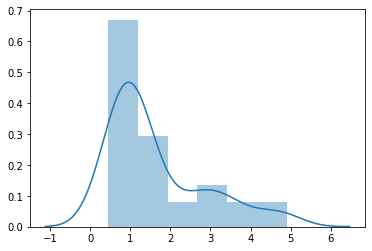

In [44]:
sns.distplot(y_trainval)
#df2.loc[:,"WEATHER_DELAY"] = np.log1p(df2["WEATHER_DELAY"])
plt.show()

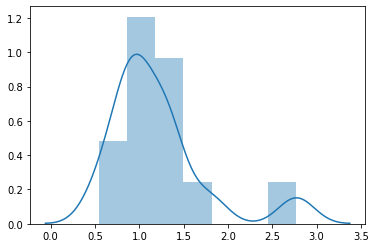

In [45]:
sns.distplot(y_test)
#df2.loc[:,"WEATHER_DELAY"] = np.log1p(df2["WEATHER_DELAY"])
plt.show()

In [46]:
other_params = {'learning_rate':0.1,'n_estimators': 100, 'max_depth': 3, 'min_child_weight': 1,'seed':1850,
               'subsample': 0.8, 'colsample_bytree': 0.8,'colsample_bylevel':1,'reg_alpha':0.01,'reg_lambda':1,
               'gamma':0.2,'objective':"reg:linear"}

model = xgb.XGBRegressor(**other_params) 
model.fit(X_trainval,y_trainval)  ## 默認rmse


# 訓練集
y_trainval_pred = model.predict(X_trainval)
mse = np.sqrt(mean_squared_error(y_trainval, y_trainval_pred))
print("訓練集mes:",mse)
r2 = metrics.r2_score(y_trainval,y_trainval_pred)
print("訓練集r2:",r2)
print("-----------------------------")

#測試集
y_test_pred = model.predict(X_test)
mse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("測試集mes:",mse)
r2 = metrics.r2_score(y_test, y_test_pred)
print("測試集r2:",r2)

[22:55:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
訓練集mes: 0.21726556956093038
訓練集r2: 0.9668199875093347
-----------------------------
測試集mes: 0.35341876074760964
測試集r2: 0.5858186153373053


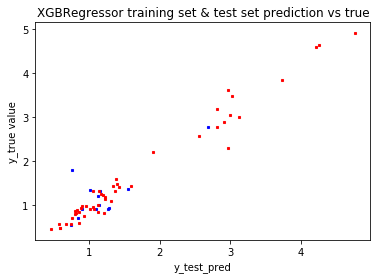

In [47]:
import matplotlib.pyplot as plt

plt.figure()

plt.scatter(y_test_pred,y_test,marker='X',s=5,c='blue')

plt.scatter(y_trainval_pred,y_trainval,marker='X',s=5,c='red')

plt.title('XGBRegressor training set & test set prediction vs true')

plt.xlabel('y_test_pred')

plt.ylabel('y_true value')

plt.show()